In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Optional, Tuple

import torch 
from torch import nn
from torchvision.datasets import CIFAR10
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms

from IPython.display import clear_output
import time

In [2]:
def get_activation(name: str, **kwargs) -> nn.Module:
    activations = {
        'relu': nn.ReLU,
        'tanh': nn.Tanh,
        'sigmoid': nn.Sigmoid,
        'silu': nn.SiLU,
        'softplus': nn.Softplus,
        'leakyrelu': nn.LeakyReLU
    }
    if name in activations.keys():
        return activations[name.lower()](**kwargs)
    else:
        raise KeyError('No such activation')

In [3]:
class ResidualBlock(nn.Module):
    def __init__(
            self,
            type: str,
            in_channels: int,
            out_channels: Optional[int] = None,
            mid_channels: Optional[int] = None,
            activations: List[str] | str = 'relu',
            kernel_size: int = 3,
            stride: int = 1,
            padding: int = 1
    ) -> None:
        super(ResidualBlock, self).__init__()
        
        n_layers = 2
        
        if not isinstance(activations, List):
            activations = [activations] * n_layers
        if len(activations) != n_layers:
            raise Exception('Not enough activations')
        
        match type.lower():
            case 'standard':
                mid_channels = mid_channels or in_channels
                out_channels = out_channels or in_channels
                
                self.layers = nn.Sequential(
                    nn.Conv2d(in_channels, mid_channels, kernel_size=kernel_size, stride=stride, padding=padding),
                    nn.BatchNorm2d(mid_channels),
                    get_activation(activations[0]),
                    
                    nn.Conv2d(mid_channels, out_channels, kernel_size=kernel_size, padding=padding),
                    nn.BatchNorm2d(out_channels)
                )
            case 'bottleneck':
                mid_channels = mid_channels or in_channels // 2
                out_channels = out_channels or in_channels
                
                self.layers = nn.Sequential(
                    nn.Conv2d(in_channels, mid_channels, kernel_size=1),
                    nn.BatchNorm2d(mid_channels),
                    get_activation(activations[0]),
                    
                    nn.Conv2d(mid_channels, mid_channels, kernel_size=kernel_size, stride=stride, padding=padding),
                    nn.BatchNorm2d(mid_channels),
                    get_activation(activations[1]),
                    
                    nn.Conv2d(mid_channels, out_channels, kernel_size=1),
                    nn.BatchNorm2d(out_channels)
                )
            case _:
                raise Exception('Unsupported block type')
                
        self.activation = get_activation(activations[-1])
        
        self.sc_pool = None
        self.sc_scale = None
        
        # if stride > 1:
        #     self.sc_pool = nn.AvgPool2d(kernel_size=stride, stride=stride)
        if in_channels != out_channels or stride > 1:
            self.sc_scale = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        shortcut = x
        
        x = self.layers(x)
                
        if self.sc_pool:
            shortcut = self.sc_pool(shortcut)
        if self.sc_scale:
            shortcut = self.sc_scale(shortcut)
        
        x = self.activation(shortcut + x)
        return x
print(ResidualBlock('Standard', 2, 4, stride=2)(torch.rand(1, 2, 10, 10)).shape)
print(ResidualBlock('Bottleneck', 2, 4, stride=2)(torch.rand(1, 2, 10, 10)).shape)
print(ResidualBlock('Standard', 2)(torch.rand(1, 2, 10, 10)).shape)
print(ResidualBlock('Bottleneck', 2)(torch.rand(1, 2, 10, 10)).shape)

torch.Size([1, 4, 5, 5])
torch.Size([1, 4, 5, 5])
torch.Size([1, 2, 10, 10])
torch.Size([1, 2, 10, 10])


In [4]:
class ResidualLayer(nn.Module):
    def __init__(
            self,
            block_type: str,
            n_blocks: int,
            in_channels: int,
            out_channels: Optional[int] = None,
            activations: List[str] | str = 'relu',
            stride=2
    ) -> None:
        super(ResidualLayer, self).__init__()
        
        if not isinstance(activations, List):
            activations = [activations] * n_blocks
        if len(activations) != n_blocks:
            raise Exception('Not enough activations')
        
        out_channels = out_channels or in_channels
        
        self.block1 = ResidualBlock(block_type, in_channels, out_channels, stride=stride, activations=activations[0])
        self.same_blocks = nn.Sequential(*[ResidualBlock(block_type, out_channels, activations=activations[i]) for i in range(1, n_blocks)])
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.block1(x)
        x = self.same_blocks(x)
        return x
ResidualLayer('Standard', 2, 2, activations=['relu', ['tanh', 'relu']])

ResidualLayer(
  (block1): ResidualBlock(
    (layers): Sequential(
      (0): Conv2d(2, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (activation): ReLU()
    (sc_scale): Conv2d(2, 2, kernel_size=(1, 1), stride=(2, 2))
  )
  (same_blocks): Sequential(
    (0): ResidualBlock(
      (layers): Sequential(
        (0): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Tanh()
        (3): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (activation): ReLU()
    )
  )
)

In [5]:
class ResNet(nn.Module):
    def __init__(
            self,              
            image_shape: Tuple[int],
            architecture: Optional[int] = None,
            layers: Optional[List[int]] = None,
            block_type: Optional[str] = None,
            activations: List[str] | str = 'relu',
            dropout_rate: int = .5
    ) -> None:
        super(ResNet, self).__init__()
        
        match architecture:
            case 18:
                block_type = 'Standard'
                layers = [2, 2, 2, 2]
            case 34:
                block_type = 'Standard'
                layers = [3, 4, 6, 3]
            case 50:
                block_type = 'Bottleneck'
                layers = [3, 4, 6, 3]
            case 101:
                block_type = 'Bottleneck'
                layers = [3, 4, 23, 3]
            case 152:
                block_type = 'Bottleneck'
                layers = [3, 8, 36, 3]
            case _:
                raise Exception('Unknown architecture')
        
        n_layers = len(layers)
        
        if not isinstance(activations, List):
            activations = [activations] * n_layers
        if len(activations) != n_layers:
            raise Exception('Not enough activations')
        
        in_channels, img_height, img_width = image_shape
        img_size = min(img_height, img_width) // 4
        cur_channels = 64
        
        self.conv1 = nn.Conv2d(in_channels, cur_channels, kernel_size=7, stride=2, padding=3)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.convs = nn.ModuleList([ResidualLayer(block_type, layers[0], cur_channels, stride=1)])
        for layer_size in layers[1:]:
            self.convs.append(ResidualLayer(block_type, layer_size, cur_channels, cur_channels*2))
            cur_channels *= 2
            img_size //= 2
            if img_size == 0:
                raise Exception('Image compressed too much')
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(cur_channels, 10)
        
    def die(self):
        for p in self.parameters():
            del p
        del self
        torch.cuda.empty_cache()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.maxpool(x)
        for conv in self.convs:
            x = conv(x)
            
        x = self.avg_pool(x).squeeze(2, 3)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

In [6]:
ResNet((1, 32, 32), architecture=18)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (convs): ModuleList(
    (0): ResidualLayer(
      (block1): ResidualBlock(
        (layers): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (activation): ReLU()
      )
      (same_blocks): Sequential(
        (0): ResidualBlock(
          (layers): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
  

In [7]:
# Transfering all data to GPU
device = torch.device('cuda')

train_dataset = CIFAR10('cifar10', transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
train_X, train_y = next(iter(train_loader))
valid_dataset = CIFAR10('cifar10', transform=transforms.ToTensor(), train=False)
valid_loader = DataLoader(valid_dataset, batch_size=len(valid_dataset))
valid_X, valid_y = next(iter(valid_loader))

train_X = train_X.to(device)
train_y = train_y.to(device)
valid_X = valid_X.to(device)
valid_y = valid_y.to(device)

In [9]:
batch_size = 1000
train_dataset = TensorDataset(train_X, train_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataset = TensorDataset(valid_X, valid_y)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

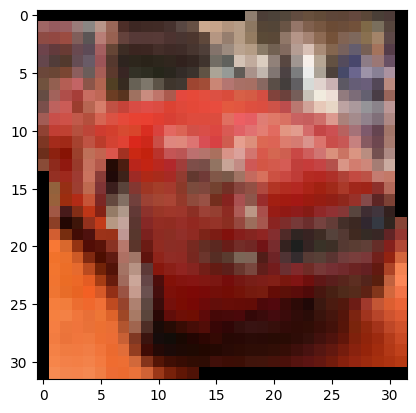

In [10]:
transform = transforms.RandomAffine(degrees=(-10, 10), translate=(.05, .05), scale=(.9, 1.1), shear=(.1, .1))
plt.imshow(transform(train_dataset.__getitem__(5)[0]).cpu().numpy().transpose(1, 2, 0))

In [11]:
def test_model(model, epochs=100, lr=1e-3, decay=1):
    transform = transforms.RandomAffine(degrees=(-10, 10), translate=(.1, .1), scale=(.9, 1.15), shear=(.1, .1))
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loss_train_list = []
    loss_valid_list = []
    final_accuracy = 0
    elapsed_time = 5
    for epoch in range(epochs):
        loss_train = 0
        loss_valid = 0
        
        start = time.time()
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X = transform(batch_X)
            optimizer.zero_grad()
            outputs = model.forward(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            loss_train += loss
            
        loss_train_list.append(loss_train.item() / len(train_loader))
            
        model.eval()
        with torch.no_grad():
            for batch_X, batch_y in valid_loader:
                batch_X = transform(batch_X)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                
                loss_valid += loss
            
        loss_valid_list.append(loss_valid.item() / len(valid_loader))
            
        #lr decay
        optimizer.param_groups[0]['lr'] = lr / (1 + decay*epoch)
        
        torch.cuda.empty_cache()
        elapsed_time = .7 * elapsed_time + .3 * (time.time() - start)
        clear_output()
        print(f'Epoch {epoch+1}/{epochs} completed. Time remaining: {(epochs - epoch - 1) * elapsed_time / 60:.2f}m')
    
    model.eval()
    with torch.no_grad():
        for batch_X, batch_y in valid_loader:
            batch_X = transform(batch_X)
            predicts = np.argmax(model(batch_X).cpu().numpy(), axis=1)
            final_accuracy += (predicts == batch_y.cpu().numpy()).sum()
        
    final_accuracy /= len(valid_dataset)
    print(f'Validation accuracy after training: {final_accuracy}')
    fig, ax = plt.subplots()
    ax.plot(loss_train_list, label='Train loss')
    ax.plot(loss_valid_list, label='Validation loss')
    plt.legend()
    
    model.die()

Epoch 100/100 completed. Time remaining: 0.00m
Validation accuracy after training: 0.6735


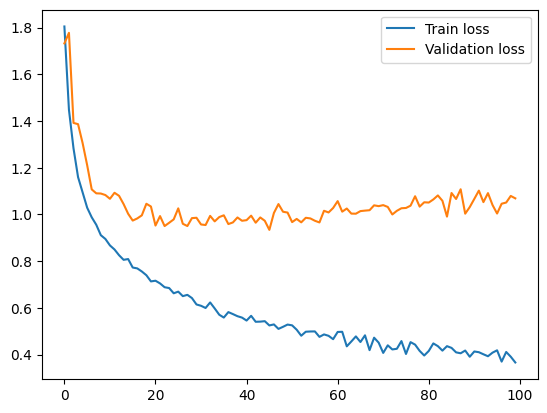

In [12]:
test_model(ResNet(train_X[0].shape, architecture=18).to(device))

Epoch 100/100 completed. Time remaining: 0.00m
Validation accuracy after training: 0.6626


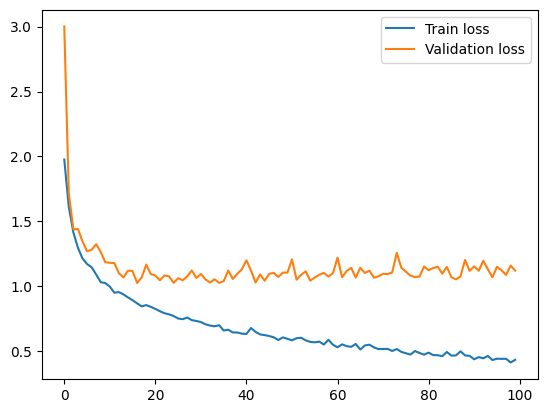

In [13]:
test_model(ResNet(train_X[0].shape, architecture=34).to(device))

Epoch 100/100 completed. Time remaining: 0.00m
Validation accuracy after training: 0.5047


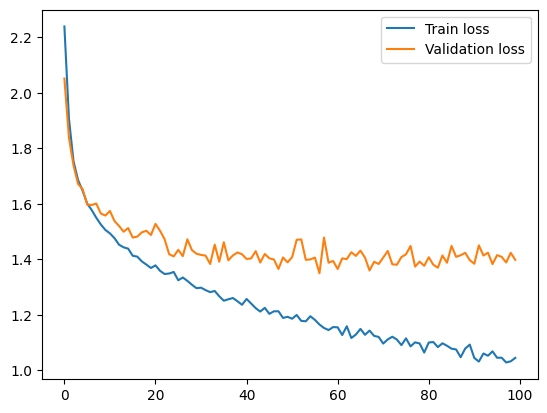

In [14]:
test_model(ResNet(train_X[0].shape, architecture=50).to(device))

Epoch 100/100 completed. Time remaining: 0.00m
Validation accuracy after training: 0.5024


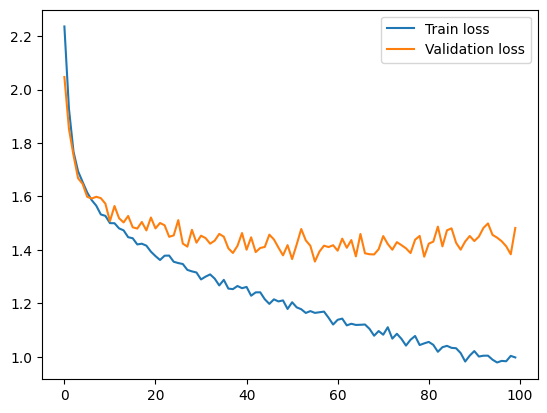

In [15]:
test_model(ResNet(train_X[0].shape, architecture=101).to(device))

Epoch 100/100 completed. Time remaining: 0.00m
Validation accuracy after training: 0.4814


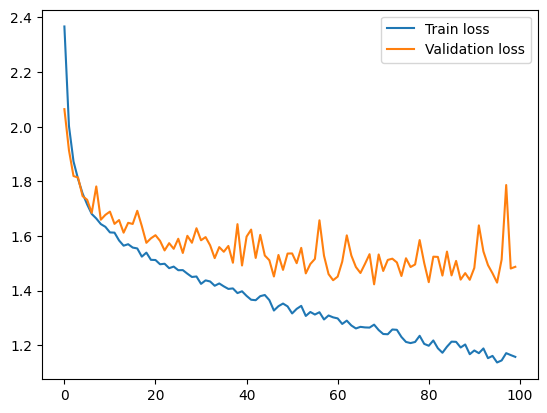

In [16]:
test_model(ResNet(train_X[0].shape, architecture=152).to(device))